In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [3]:
train_df = pd.read_csv("./fhs_train.csv", low_memory=False)
train_df = train_df.drop("Unnamed: 0", axis=1)
display(train_df.head())
print(train_df.isna().sum())

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,58,1.0,0,0.0,0.0,0,0,0,220.0,143.0,104.0,29.85,75,87.0,1
1,0,40,1.0,1,15.0,0.0,0,0,0,199.0,122.0,82.0,22.16,85,77.0,0
2,0,52,1.0,0,0.0,0.0,0,0,0,275.0,112.0,71.0,25.68,80,NaN,0
3,1,38,2.0,1,43.0,0.0,0,1,0,170.0,130.0,94.0,23.90,110,75.0,0
4,0,43,1.0,0,0.0,0.0,0,0,0,202.0,124.0,92.0,21.26,75,74.0,0


sex                  0
age                  0
education           85
currentSmoker        0
cigsPerDay          24
BPMeds              37
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             39
sysBP                0
diaBP                0
BMI                 15
heartRate            0
glucose            285
TenYearCHD           0
dtype: int64


In [4]:
train_df.describe()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3180.000000,3180.000000,3095.000000,3180.000000,3156.000000,3143.000000,3180.000000,3180.000000,3180.000000,3141.000000,3180.000000,3180.000000,3165.000000,3180.000000,2895.000000,3180.000000
mean,0.433019,49.633962,1.957027,0.490881,8.970532,0.029590,0.006604,0.321069,0.026101,236.600764,132.784748,83.117767,25.888117,75.942138,81.833506,0.153145
std,0.495571,8.557596,1.011135,0.499995,12.013704,0.169479,0.081008,0.466961,0.159460,44.847411,22.433267,12.009212,4.130475,12.050504,23.625357,0.360184
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,50.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000,117.000000,75.000000,23.100000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,233.000000,129.000000,82.000000,25.490000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,144.125000,90.000000,28.140000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,140.000000,394.000000,1.000000


In [5]:
print(train_df.shape)
print(train_df["TenYearCHD"].value_counts()) # 15.31% have chd
drop_train_df = train_df.dropna()
print(drop_train_df.shape) # 86.29% of train_df
print(drop_train_df["TenYearCHD"].value_counts()) # 15.45% have chd
na_train_df = train_df[train_df.isna().any(axis=1)]
print(na_train_df.shape) # 13.71% of train_df
print(na_train_df["TenYearCHD"].value_counts()) # 14.45% have chd

# for now choose to drop na values

(3180, 16)
TenYearCHD
0    2693
1     487
Name: count, dtype: int64
(2744, 16)
TenYearCHD
0    2320
1     424
Name: count, dtype: int64
(436, 16)
TenYearCHD
0    373
1     63
Name: count, dtype: int64


In [6]:
test_df = pd.read_csv("./fhs_test.csv", low_memory=False)
test_df = test_df.drop("Unnamed: 0", axis=1)
display(test_df.head())
print(test_df.isna().sum())

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,58,1.0,1,20.0,0.0,0,0,0,NaN,126.0,77.0,30.08,78.0,NaN,0
1,0,51,3.0,0,0.0,0.0,0,0,0,264.0,135.0,83.0,26.68,60.0,74.0,0
2,0,44,2.0,1,9.0,0.0,0,1,0,NaN,147.5,96.0,30.57,78.0,NaN,1
3,0,40,2.0,1,20.0,0.0,0,0,0,271.0,138.5,88.0,27.24,80.0,NaN,1
4,1,58,2.0,1,20.0,0.0,0,0,0,207.0,110.0,80.0,23.55,78.0,78.0,0


sex                  0
age                  0
education           20
currentSmoker        0
cigsPerDay           5
BPMeds              16
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             11
sysBP                0
diaBP                0
BMI                  4
heartRate            1
glucose            103
TenYearCHD           0
dtype: int64


In [7]:
test_df.describe()

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,1060.000000,1060.000000,1040.000000,1060.000000,1055.000000,1044.000000,1060.000000,1060.000000,1060.000000,1049.000000,1060.000000,1060.000000,1056.000000,1059.000000,957.000000,1060.000000
mean,0.417925,49.418868,2.046154,0.503774,9.111848,0.029693,0.003774,0.279245,0.024528,236.995234,131.064151,82.237736,25.539100,75.689330,82.357367,0.148113
std,0.493450,8.620858,1.042774,0.500222,11.650215,0.169822,0.061342,0.448840,0.154755,43.835233,20.743991,11.589415,3.914418,11.953153,24.931659,0.355380
min,0.000000,34.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,124.000000,92.500000,48.000000,15.960000,45.000000,44.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,74.000000,22.850000,68.000000,72.000000,0.000000
50%,0.000000,49.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,235.000000,127.000000,81.000000,25.140000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,265.000000,140.125000,88.000000,27.860000,82.000000,87.000000,0.000000
max,1.000000,69.000000,4.000000,1.000000,60.000000,1.000000,1.000000,1.000000,1.000000,453.000000,215.000000,140.000000,45.790000,143.000000,394.000000,1.000000


In [8]:
print(test_df.shape)
print(test_df["TenYearCHD"].value_counts()) # 14.81% have chd
drop_test_df = test_df.dropna()
print(drop_test_df.shape) # 86.23% of train_df
print(drop_test_df["TenYearCHD"].value_counts()) # 14.55% have chd
na_test_df = test_df[test_df.isna().any(axis=1)]
print(na_test_df.shape) # 13.77% of train_df
print(na_test_df["TenYearCHD"].value_counts()) # 16.44% have chd

# for now choose to drop na values

(1060, 16)
TenYearCHD
0    903
1    157
Name: count, dtype: int64
(914, 16)
TenYearCHD
0    781
1    133
Name: count, dtype: int64
(146, 16)
TenYearCHD
0    122
1     24
Name: count, dtype: int64


In [35]:
display(drop_train_df.corr())
display(drop_test_df.corr())
# let's pick out correlations with an absolute value greater than 0.5:
    # currentSmoker and cigsPerDay are correlated
    # prevalentHyp and sysBP and diaBP are correlated
    # diabetes and glucose are correlated

# glucose has the most missing values and it is correlated with diabetes, so droping these values might have an impact on our final models
# cigsPerDay also has a few missing values but not as many as glucose, could also impact final models

,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
sex,1.000000,-0.030139,0.005061,0.205028,0.336615,-0.044798,0.012356,0.008453,0.016438,-0.076235,-0.034453,0.057362,0.074355,-0.111224,0.013454,0.100394
age,-0.030139,1.000000,-0.166460,-0.212695,-0.195504,0.128098,0.056119,0.294195,0.097253,0.269450,0.386833,0.208598,0.143422,-0.010926,0.103984,0.233327
education,0.005061,-0.166460,1.000000,0.019864,0.008876,-0.015253,-0.024027,-0.073242,-0.042965,-0.015273,-0.126289,-0.059369,-0.150767,-0.085380,-0.039952,-0.058663
currentSmoker,0.205028,-0.212695,0.019864,1.000000,0.770227,-0.057604,-0.039969,-0.107898,-0.031604,-0.027983,-0.140898,-0.115857,-0.176905,0.047681,-0.056631,0.007957
cigsPerDay,0.336615,-0.195504,0.008876,0.770227,1.000000,-0.048006,-0.034373,-0.071204,-0.032327,-0.017445,-0.096031,-0.050059,-0.094391,0.067819,-0.059574,0.050614
BPMeds,-0.044798,0.128098,-0.015253,-0.057604,-0.048006,1.000000,0.121645,0.255967,0.047991,0.088243,0.267308,0.207486,0.093656,-0.005011,0.031285,0.095222
prevalentStroke,0.012356,0.056119,-0.024027,-0.039969,-0.034373,0.121645,1.000000,0.054817,-0.013326,0.005556,0.060481,0.050653,0.014946,-0.024515,0.000245,0.043344
prevalentHyp,0.008453,0.294195,-0.073242,-0.107898,-0.071204,0.255967,0.054817,1.000000,0.083085,0.163553,0.689293,0.617183,0.308250,0.145399,0.084884,0.168785
diabetes,0.016438,0.097253,-0.042965,-0.031604,-0.032327,0.047991,-0.013326,0.083085,1.000000,0.052329,0.094032,0.044307,0.086245,0.054426,0.607184,0.099882
totChol,-0.076235,0.269450,-0.015273,-0.027983,-0.017445,0.088243,0.005556,0.163553,0.052329,1.000000,0.218192,0.156686,0.114871,0.080965,0.035636,0.113374


,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
sex,1.000000,-0.008184,0.059335,0.209998,0.310308,-0.074139,-0.056433,-0.025371,0.004769,-0.051571,-0.084723,0.031030,0.064621,-0.128771,-0.025377,0.063633
age,-0.008184,1.000000,-0.139154,-0.205061,-0.170595,0.154252,0.032935,0.343572,0.145716,0.265086,0.393690,0.206948,0.118287,0.021491,0.158242,0.235883
education,0.059335,-0.139154,1.000000,0.040483,0.029951,-0.009616,-0.050864,-0.089315,-0.028616,-0.010134,-0.113686,-0.048286,-0.090300,-0.001512,-0.012671,-0.075425
currentSmoker,0.209998,-0.205061,0.040483,1.000000,0.786340,-0.034987,-0.031994,-0.108659,-0.074039,-0.120069,-0.113899,-0.116214,-0.104552,0.060502,-0.044028,0.053774
cigsPerDay,0.310308,-0.170595,0.029951,0.786340,1.000000,-0.041831,-0.044021,-0.069470,-0.052453,-0.070802,-0.091859,-0.079421,-0.065074,0.051819,-0.036637,0.056246
BPMeds,-0.074139,0.154252,-0.009616,-0.034987,-0.041831,1.000000,0.084397,0.285782,0.052511,0.111419,0.285149,0.176543,0.145520,0.066804,0.117862,0.070681
prevalentStroke,-0.056433,0.032935,-0.050864,-0.031994,-0.044021,0.084397,1.000000,0.106582,0.095174,0.038876,0.062074,0.073557,0.118421,0.009396,0.069377,0.066650
prevalentHyp,-0.025371,0.343572,-0.089315,-0.108659,-0.069470,0.285782,0.106582,1.000000,0.071383,0.178641,0.724027,0.617213,0.279844,0.150517,0.095514,0.220643
diabetes,0.004769,0.145716,-0.028616,-0.074039,-0.052453,0.052511,0.095174,0.071383,1.000000,0.036626,0.130404,0.070201,0.097631,0.081612,0.641001,0.072371
totChol,-0.051571,0.265086,-0.010134,-0.120069,-0.070802,0.111419,0.038876,0.178641,0.036626,1.000000,0.227760,0.230341,0.143764,0.129860,0.089138,0.024272


In [101]:
xtrain = drop_train_df.drop("TenYearCHD", axis=1)
xtest = drop_test_df.drop("TenYearCHD", axis=1)
ytrain = drop_train_df["TenYearCHD"]
ytest = drop_test_df["TenYearCHD"]
print(ytrain.describe())
print(ytest.describe())

ntest = len(ytest)
tss = np.sum((ytest - ytrain.mean()) ** 2)

count    2744.000000
mean        0.154519
std         0.361511
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: TenYearCHD, dtype: float64
count    914.000000
mean       0.145514
std        0.352812
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: TenYearCHD, dtype: float64


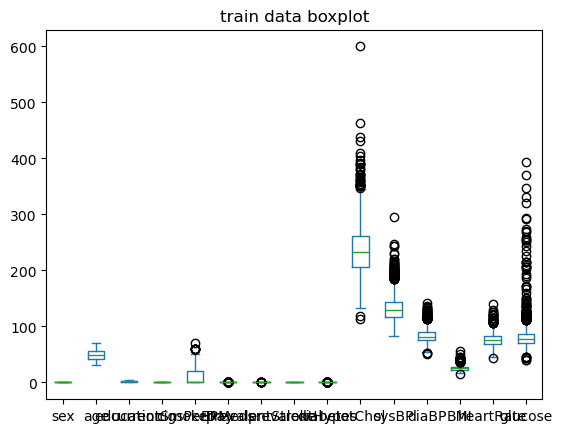

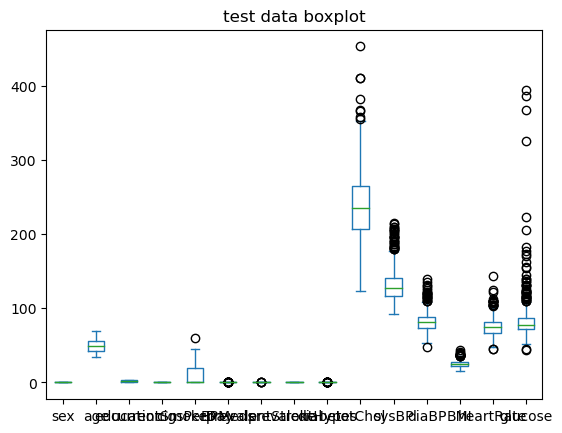

In [10]:
xtrain.plot.box()
plt.title("train data boxplot")
plt.show()
xtest.plot.box()
plt.title("test data boxplot")
plt.show()
# only sex, age, education, currentsmoker, and prevalenthyp do not have outliers

In [75]:
%%capture --no-display
%%script echo skipping

# can redefine train and test based on the variables that the tree chose because those seem the most predictive:
select_drop_train_df = drop_train_df[["sex", "age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "glucose", "TenYearCHD"]]
select_drop_test_df = drop_test_df[["sex", "age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "glucose", "TenYearCHD"]]
xtrain = select_drop_train_df.drop("TenYearCHD", axis=1)
ytrain = select_drop_train_df["TenYearCHD"]
xtest = select_drop_test_df.drop("TenYearCHD", axis=1)
ytest = select_drop_test_df["TenYearCHD"]


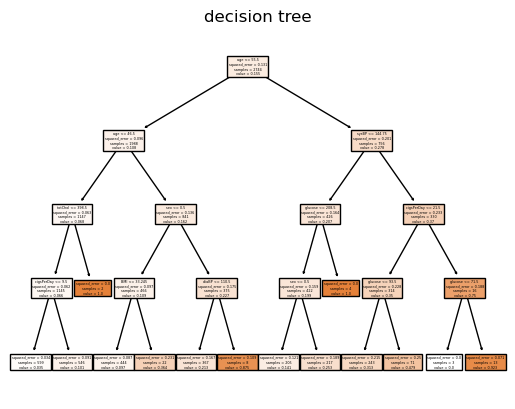

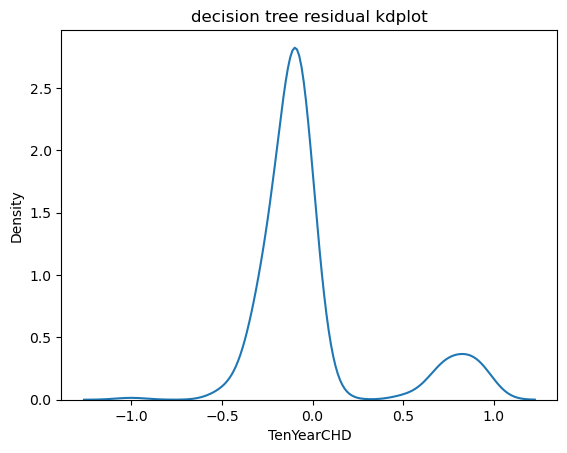

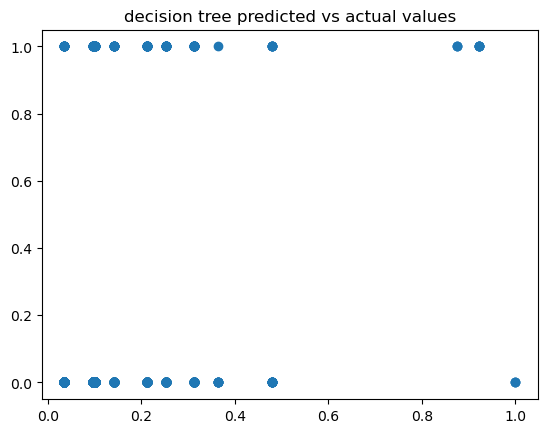

In [113]:
# tree approach:

cart = DecisionTreeRegressor(max_depth=4).fit(xtrain, ytrain)
varnames = list(cart.feature_names_in_)
plot_tree(cart, filled=True, feature_names=varnames)
plt.title("decision tree")
plt.savefig("./tree.png", dpi=500)
plt.show()

yhat_tree = cart.predict(xtest)
residual = ytest - yhat_tree
sns.kdeplot(residual).set_title("decision tree residual kdplot")
plt.show()

plt.scatter(x=yhat_tree, y=ytest)
plt.title("decision tree predicted vs actual values")
plt.show()

sse_tree = np.sum((ytest - yhat_tree) ** 2)
mse_tree = sse_tree / ntest
rmse_tree = np.sqrt(sse_tree / ntest)
r2_tree = 1 - sse_tree / tss

minimum SSE: 105.26125; optimal k: 40


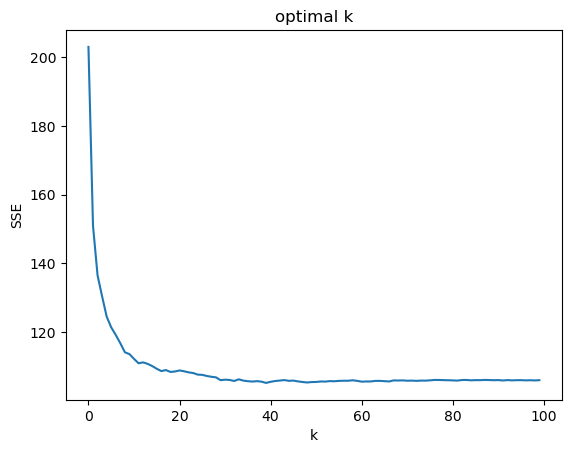

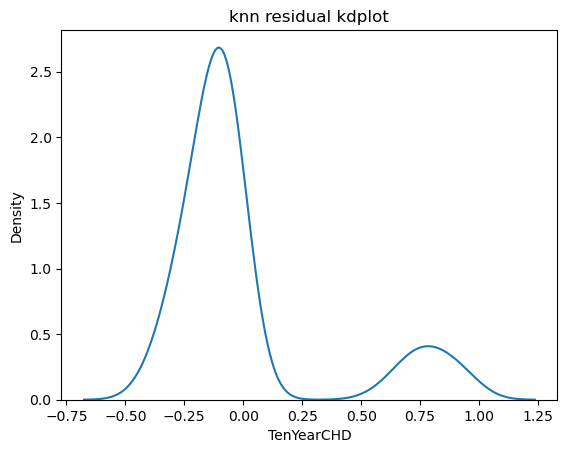

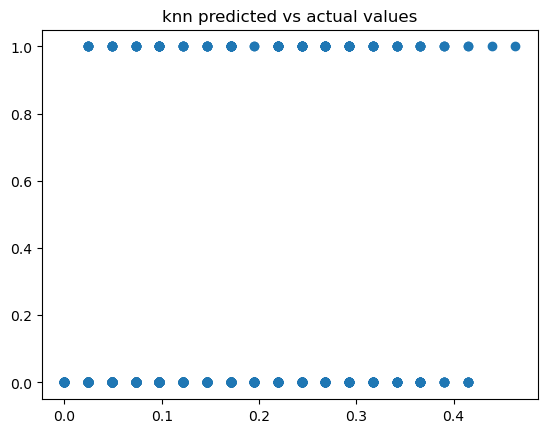

In [115]:
# kNN approach:
def maxmin(x):
    return (x - min(x)) / (max(x) - min(x))

xtrain_knn = xtrain.apply(maxmin)
xtest_knn = xtest.apply(maxmin)

karr = np.arange(1, 101)
sse = np.zeros(100)
ssemin = np.min(sse)
for k in range(100):
    model = KNeighborsRegressor(n_neighbors=k + 1).fit(xtrain_knn, ytrain)
    yhat = model.predict(xtest_knn)
    sse[k] = np.sum((ytest - yhat) ** 2)

ssemin = np.min(sse)
index = np.where(sse == ssemin)[0]
opt = karr[index]
print(f"minimum SSE: {ssemin}; optimal k:", end=" ")
print(*opt, sep=", ")
plt.plot(np.arange(100), sse)
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("optimal k")
plt.show()

model = KNeighborsRegressor(n_neighbors=opt[0] + 1).fit(xtrain_knn, ytrain)
yhat_knn = model.predict(xtest_knn)
residual = ytest - yhat_knn
sns.kdeplot(residual).set_title("knn residual kdplot")
plt.show()

plt.scatter(x=yhat_knn, y=ytest)
plt.title("knn predicted vs actual values")
plt.show()

sse_knn = np.sum((ytest - yhat_knn) ** 2)
mse_knn = sse_knn / ntest
rmse_knn = np.sqrt(sse_knn / ntest)
r2_knn = 1 - sse_knn / tss

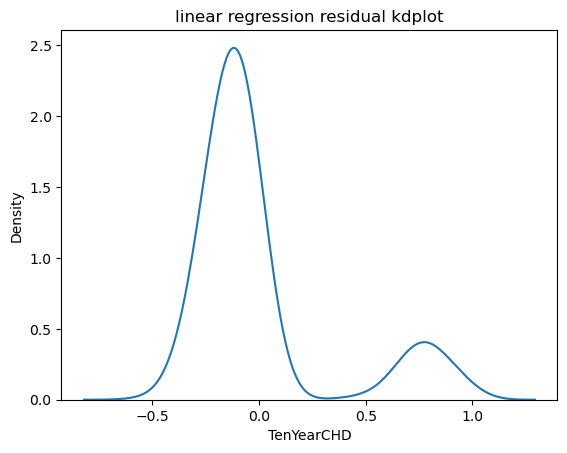

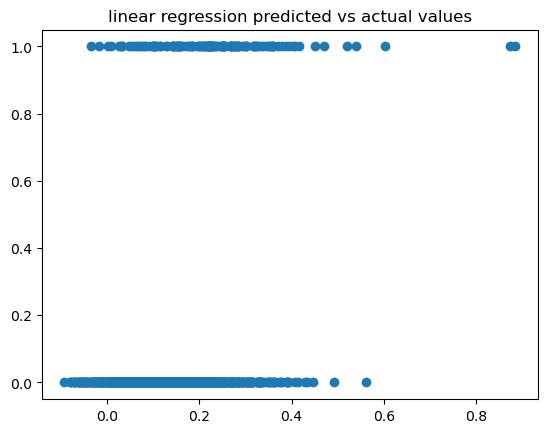

In [114]:
# linear regression approach:
reg = LinearRegression().fit(xtrain, ytrain)
yhat_lr = reg.predict(xtest)
residual = ytest - yhat_lr
sns.kdeplot(residual).set_title("linear regression residual kdplot")
plt.show()

plt.scatter(x=yhat_lr, y=ytest)
plt.title("linear regression predicted vs actual values")
plt.show()

sse_lr = np.sum((ytest - yhat_lr) ** 2)
mse_lr = sse_lr / ntest
rmse_lr = np.sqrt(sse_lr / ntest)
r2_lr = 1 - sse_lr / tss

In [116]:
# comparison table:

cdf = pd.DataFrame({"SSE": [sse_tree, sse_knn, sse_lr], "MSE": [mse_tree, mse_knn, mse_lr], "RMSE": [rmse_tree, rmse_knn, rmse_lr], "R2": [r2_tree, r2_knn, r2_lr]})
cdf.index = ['TREE','LR','kNN']
cdf.head()

# analyze why these models did so poorly, professor suggests looking at https://en.wikipedia.org/wiki/Coronary_artery_disease to find out if the variables we have are actually strong predictors or not
# could also be different if we imputed values, analyze why some of the non-response is correlated (there is a section in the background pdf on non-response bias)
# could be improved if we only regressed on the variables that the tree chose
# maybe it's just a really far fetched idea to be able to predict CHD ten years later - a lot can change in ten years

,SSE,MSE,RMSE,R2
TREE,105.868932,0.115830,0.340339,0.069044
LR,105.588340,0.115523,0.339887,0.071512
kNN,103.207006,0.112918,0.336033,0.092452
